### 1- Préparation des données

In [1]:
import pandas as pd
data = pd.read_csv('donnees_nettoyees.csv', sep=";")
print(type(data))

#print(data.head(5))
data.info

<class 'pandas.core.frame.DataFrame'>


<bound method DataFrame.info of                 X            Y  OBJECTID     src_geo  \
0     1720320.108  8294619.356         1  Orthophoto   
1     1720898.301  8293531.134         2  Orthophoto   
2     1720893.840  8293542.450         3  Orthophoto   
3     1720901.650  8293545.467         4  Orthophoto   
4     1721089.065  8293619.339         5  Orthophoto   
...           ...          ...       ...         ...   
9025  1721738.392  8295825.625     12030  Orthophoto   
9026  1718512.660  8293671.382     12033  Orthophoto   
9027  1721676.588  8295878.677     12035  Orthophoto   
9028  1721704.512  8295829.743     12036  Orthophoto   
9029  1721757.045  8295872.979     12037  Orthophoto   

                  clc_quartier              clc_secteur  haut_tot  haut_tronc  \
0     Quartier du Centre-Ville      Boulevard Richelieu       0.0         0.0   
1     Quartier du Centre-Ville      Boulevard Leon Blum       0.0         0.0   
2     Quartier du Centre-Ville      Boulevard Leon B

### 2- Apprentissage supervisé pour la régression

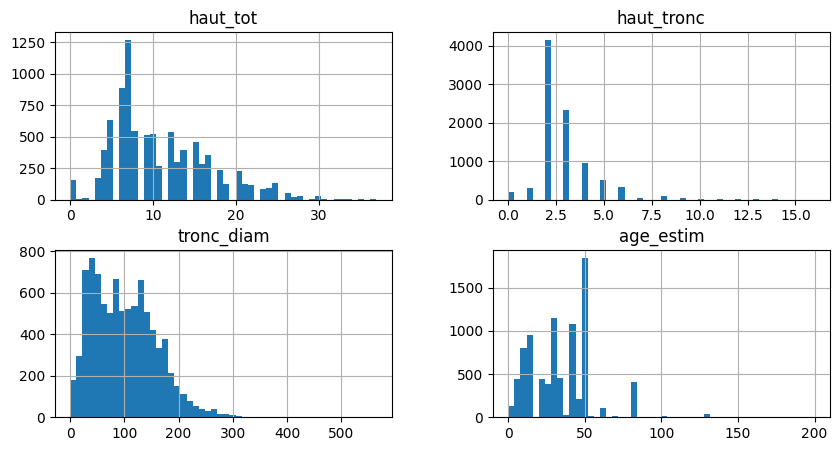

In [2]:
#data.value_counts("haut_tot")
data.describe()

import matplotlib.pyplot as plt
data[["haut_tot", "haut_tronc", "tronc_diam", "age_estim"]].hist(bins=50, figsize=(10,5))
plt.show()


Répartition des données

In [3]:
# Base de données de près de 10 000 lignes, on a choisi une répartirion 80/20.
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

#train_set.head()
print(len(train_set))
print("\n")
#test_set.head()
print(len(test_set))

7224


1806


Il va falloir qu'on netoie un peu les informations qu'on a à disposition et qu'on sépare les features de la valeur cible. Le chi2 avait de plus fonctionné avec pas mal de valeurs qualitatives qu'il va falloir passer en numérique afin que la phase d'apprentissage soit plus simple pour le programme.

In [4]:
#séparation des features et de la valeur cible
train_data = train_set.drop("age_estim", axis=1) #drop labels for training set
#print(train_data)
train_labels = train_set["age_estim"].copy()
print(train_labels)


test_data = test_set.drop("age_estim", axis=1)
#print(test_data)
test_labels = test_set["age_estim"].copy()
print(test_labels)

4477    30.0
2766    40.0
2484    50.0
5244    40.0
4801    30.0
        ... 
5734    30.0
5191    35.0
5390     5.0
860     50.0
7270    15.0
Name: age_estim, Length: 7224, dtype: float64
2373    80.0
7802    15.0
5123    30.0
6108    30.0
6011    35.0
        ... 
7756    20.0
5062    30.0
1281    15.0
971     40.0
8583    35.0
Name: age_estim, Length: 1806, dtype: float64


In [5]:
#remplacement des valeurs non remplies pour l'âge
median_age = train_labels.median()
print("valeur de la médiane : " + str(median_age))
train_labels.fillna(median_age, inplace=True)
print(train_labels.info())

valeur de la médiane : 30.0
<class 'pandas.core.series.Series'>
Index: 7224 entries, 4477 to 7270
Series name: age_estim
Non-Null Count  Dtype  
--------------  -----  
7224 non-null   float64
dtypes: float64(1)
memory usage: 112.9 KB
None


In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Initialiser l'OrdinalEncoder
encoder = OrdinalEncoder()

# Appliquer l'encodeur aux colonnes sélectionnées
train_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.fit_transform(train_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]])
test_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.fit_transform(test_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]])
# Afficher les premières valeurs des colonnes encodées
#train_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]].head(10)

train_data = train_data[["clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"]]
test_data = test_data[["clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"]]
#train_data.head(10)

# Nettoyage restant pour les colones d'entrée
cols_to_fill = ["clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"]

for col in cols_to_fill:
    median_value = train_data[col].median()
    print("median" + str(col) + " " + str(median_value))
    train_data[col].fillna(median_value, inplace=True)

#print(train_data.info())

# Remplacement des valeurs non remplies pour l'âge dans test_labels
test_labels.fillna(median_age, inplace=True)

# Remplissage des colonnes d'entrée pour test_data en utilisant les médianes calculées sur train_data
for col in cols_to_fill:
    median_value = train_data[col].median()
    test_data[col].fillna(median_value, inplace=True)

print(test_data.info())


medianclc_quartier 5.0
medianclc_secteur 147.0
medianhaut_tot 9.0
medianhaut_tronc 2.0
mediantronc_diam 95.0
medianfk_port 12.0
medianfk_pied 6.0
medianfk_situation 0.0
<class 'pandas.core.frame.DataFrame'>
Index: 1806 entries, 2373 to 8583
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   clc_quartier  1806 non-null   float64
 1   clc_secteur   1806 non-null   float64
 2   haut_tot      1806 non-null   float64
 3   haut_tronc    1806 non-null   float64
 4   tronc_diam    1806 non-null   float64
 5   fk_port       1806 non-null   float64
 6   fk_pied       1806 non-null   float64
 7   fk_situation  1806 non-null   float64
dtypes: float64(8)
memory usage: 127.0 KB
None


C:\Users\allan\AppData\Local\Temp\ipykernel_4388\1111274785.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(median_value, inplace=True)
C:\Users\allan\AppData\Local\Temp\ipykernel_4388\1111274785.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Apprentissage du modèle de régression linéaire : 

In [ ]:
from sklearn.linear_model import LinearRegression
#train_data.head(10)
#train_labels.head(10)
reg = LinearRegression()
reg.fit(train_data, train_labels)

In [ ]:
#évaluation du modèle d'apprentissage
predictions = reg.predict(train_data)
print("predictions : " + str(reg.predict(train_data)))
print("labels : " + str(train_labels))


predictions : [21.94545296 23.72633471 36.10104301 ... 20.72047128 54.48621465
 22.49768194]
labels : 4477    30.0
2766    40.0
2484    50.0
5244    40.0
4801    30.0
        ... 
5734    30.0
5191    35.0
5390     5.0
860     50.0
7270    15.0
Name: age_estim, Length: 7224, dtype: float64


In [ ]:
#RMSE
from numpy import sqrt
from sklearn.metrics import mean_squared_error
RMSE = sqrt(mean_squared_error(train_labels, reg.predict(train_data)))
print(RMSE)

11.54732549998008


In [ ]:
#utilisation du decisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
DecisionTreeRegressor = DecisionTreeRegressor()
DecisionTreeRegressor.fit(train_data, train_labels)

DecisionTreeRegressor()

In [ ]:
#RMSE sur DecisionTreeRegressor : 
RMSE = sqrt(mean_squared_error(train_labels, DecisionTreeRegressor.predict(train_data)))
print(RMSE)

0.6981343460632725


In [ ]:
# Créer un DataFrame avec les valeurs réelles et prédites
comparison_df = pd.DataFrame({'Réalité': train_labels, 'Prédiction': predictions})

# Afficher les 10 premières lignes du tableau
print(comparison_df.head(10))

      Réalité  Prédiction
4477     30.0   21.945453
2766     40.0   23.726335
2484     50.0   36.101043
5244     40.0   34.530851
4801     30.0   27.799112
970      40.0   55.674818
4574     30.0   42.927551
4667     15.0   18.605053
6758     30.0   21.989053
7264     15.0   26.822133


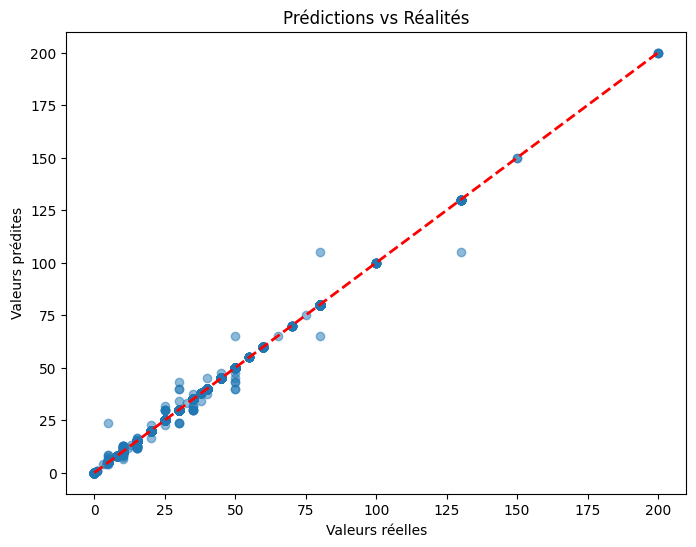

In [ ]:
import matplotlib.pyplot as plt

# Prédictions du modèle
predictions = DecisionTreeRegressor.predict(train_data)

# Création du graphique de dispersion
plt.figure(figsize=(8,6))
plt.scatter(train_labels, predictions, alpha=0.5)  # alpha pour la transparence des points
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'r--', lw=2)  # ligne y=x pour la référence
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Prédictions vs Réalités')
plt.show()

In [ ]:
#test : 

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Définir le modèle de régression (DecisionTreeRegressor)
model = DecisionTreeRegressor()
model2 = LinearRegression()



# Appliquer la validation croisée avec 10 folds, en utilisant l'argument "neg_mean_squared_error"
scores = cross_val_score(model, train_data, train_labels, cv=10, scoring="neg_mean_squared_error")
scores2 = cross_val_score(model2, train_data, train_labels, cv=10, scoring="neg_mean_squared_error")

# Convertir les scores (MSE négatifs) en RMSE (en prenant la racine carrée et en multipliant par -1)
rmse_scores = np.sqrt(-scores)
rmse_scores2 = np.sqrt(-scores2)

# a. Afficher les RMSE de chaque fold
print("RMSE de chaque fold :")
print(rmse_scores)
print(rmse_scores2)

# b. Afficher la moyenne des RMSE
mean_rmse = np.mean(rmse_scores)
mean_rmse2 = np.mean(rmse_scores2)
print("\nMoyenne des RMSE :")
print(mean_rmse)
print(mean_rmse2)

# Remettre le modèle à zéro
model = DecisionTreeRegressor()

# L'entraîner train_data
model.fit(train_data, train_labels)

# Puis prédire sur le test
test_predictions = model.predict(test_data)

# Puis calculer le RMSE
test_rmse = sqrt(mean_squared_error(test_labels, test_predictions))
print("RMSE sur le jeu de test :", test_rmse)


RMSE de chaque fold :
[ 8.97855521  8.27440437 11.0428963   7.4438307   8.23354146  8.52144167
  7.68791717  7.99182624 11.6127116   7.62883849]
[11.32426911 11.2679595  11.65183338 11.58064584 12.3150634  11.62949076
 11.75704195 11.47774391 11.64715047 10.98208706]

Moyenne des RMSE :
8.741596321089123
11.563328538006854
RMSE sur le jeu de test : 14.688796792103316


On va essayer de changer le nettoyage de la base, prendre d'autres paramètres et refaire un decision tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from numpy import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
# Charger les données
data = pd.read_csv('donnees_nettoyees.csv', sep=";")

data2 = data.copy()
encoder = OrdinalEncoder()
#data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.fit_transform(data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]])
#print(data2.dtypes)

# Remplacer les zéros par NaN pour les colonnes qu'on va prendre apres
data[['haut_tot', 'haut_tronc', 'tronc_diam']] = data[['haut_tot', 'haut_tronc', 'tronc_diam']].replace(0, pd.NA)
data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]].replace(0, pd.NA)

# Supprimer les lignes avec NaN
data1 = data.dropna(subset=["haut_tot", "haut_tronc", "tronc_diam", "age_estim"])
data2 = data.dropna(subset=["age_estim", "clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"])

#print((data == 0).sum())

# On va réessayer de séparer en 80/20
train_set, test_set = train_test_split(data1, test_size=0.2, random_state=42)
train_set2, test_set2 = train_test_split(data2, test_size=0.2, random_state=42)


# Séparation des features et de la valeur cible
train_data = train_set[["haut_tot", "haut_tronc", "tronc_diam"]]
train_labels = train_set["age_estim"]

test_data = test_set[["haut_tot", "haut_tronc", "tronc_diam"]]
test_labels = test_set["age_estim"]


train_data2 = train_set2[["clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"]]
train_labels2 = train_set2["age_estim"]

test_data2 = test_set2[["clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"]]
test_labels2 = test_set2["age_estim"]

train_data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.fit_transform(train_data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]])
test_data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.fit_transform(test_data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]])

# Utilisation du decisionTreeRegressor qui avait mieux marché avant
regressor_3 = DecisionTreeRegressor()
regressor_3.fit(train_data, train_labels)
regressor = DecisionTreeRegressor()
regressor.fit(train_data2, train_labels2)

#évaluation du modèle d'apprentissage
predictions = regressor.predict(train_data2)
#print("predictions : " + str(regressor.predict(train_data2)))
#print("labels : " + str(train_labels2))


#RMSE sur DecisionTreeRegressor : 
RMSE = sqrt(mean_squared_error(train_labels2, regressor.predict(train_data2)))
print(RMSE)


comparison_df = pd.DataFrame({'Réalité': train_labels2, 'Prédiction': predictions})


# Afficher les 10 premières lignes du tableau
#print(comparison_df.head(10))



0.5893552350783363


C:\Users\allan\AppData\Local\Temp\ipykernel_24384\3360596693.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.fit_transform(train_data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]])
C:\Users\allan\AppData\Local\Temp\ipykernel_24384\3360596693.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data2[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.f

In [ ]:
# Remettre le modèle à zéro
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
regressor = DecisionTreeRegressor()
# L'entraîner train_data
model.fit(train_data, train_labels)
regressor.fit(train_data2, train_labels2)

# Puis prédire sur le test
test_predictions = model.predict(test_data)
test_predictions2 = regressor.predict(test_data2)

# Puis calculer le RMSE
test_rmse = sqrt(mean_squared_error(test_labels, test_predictions))
test_rmse2 = sqrt(mean_squared_error(test_labels2, test_predictions2))
print("RMSE sur le jeu de test avec data 3 entrées et en supprimant les 0:", test_rmse)
print("RMSE sur le jeu de test avec data 8 entrées et en supprimant les 0:", test_rmse2)

RMSE sur le jeu de test avec data 3 entrées et en supprimant les 0: 13.466632972466796
RMSE sur le jeu de test avec data 8 entrées et en supprimant les 0: 16.04406240745401


### 3- Métriques pour la régression

On en a déjà fait des RMSE pour estimer la meilleure manière possible pour déterminer l'âge des arbres. On va maintenant tester d'autres métriques : 

In [ ]:
from sklearn.metrics import mean_absolute_error

#Comparaison Root Mean Squared Error
rmse = sqrt(mean_squared_error(test_labels, test_predictions))
rmse2 = sqrt(mean_squared_error(test_labels2, test_predictions2))

print("RMSE avec trois entrées en supprimant les 0 : " + str(rmse) + "RMSE avec huit entrées en supprimant les 0 : "+ str(rmse2))

#Comparaison Mean Absolute Error
mae2 = mean_absolute_error(test_labels2, test_predictions2)
mae = mean_absolute_error(test_labels, test_predictions) 

print("MAE avec trois entrées en supprimant les 0 : " + str(mae) + "MAE avec huit entrées en supprimant les 0 : "+ str(mae2))

#Comparaison Mean Squared Error
mse = mean_squared_error(test_labels, test_predictions) 
mse2 = mean_squared_error(test_labels2, test_predictions2) 
print("MSE avec trois entrées en supprimant les 0 : " + str(mse) + "MSE avec huit entrées en supprimant les 0 : "+ str(mse2))

RMSE avec trois entrées en supprimant les 0 : 13.466632972466796RMSE avec huit entrées en supprimant les 0 : 16.04406240745401
MAE avec trois entrées en supprimant les 0 : 8.257835862509307MAE avec huit entrées en supprimant les 0 : 8.719440967876512
MSE avec trois entrées en supprimant les 0 : 181.35020361512989MSE avec huit entrées en supprimant les 0 : 257.41193853427893


Pour toutes ces métriques, on remarque que rajouter des entrées au programme ne semble pas l'aider, malgré le fait que dans la partie Big Data on ait trouvé des corellations entre l'age et ces facteurs. Cela ressemble donc à de l'overfitting : On remarque que des 3 intelligences qu'on a pu tester (avec seulement DecisionTree), celle qui a les métriques les moins élevées est celle avec seulement 3 entrées et avec toutes les valeurs à 0 supprimées.

In [ ]:
# utilisation de  GridSearchCV pour 8 paramètres d'entrée

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from numpy import sqrt

tree = DecisionTreeRegressor(random_state=42)

# hyperparamètres
param_grid = {
    'max_depth': [3, 5, 10, 20, None],           
    'min_samples_split': [2, 5, 10],              
    'min_samples_leaf': [1, 2, 4]              
}

#Configuration du GridSearchCV
grid_search = GridSearchCV(
    tree,                     
    param_grid,               
    cv=5,                     
    scoring='neg_mean_squared_error', 
    n_jobs=-1                  
)

grid_search.fit(train_data2, train_labels2)

# meilleurs résultats
print("Meilleurs hyperparamètres :")
print(grid_search.best_params_)

#on crée le meilleur modèle
best_model = grid_search.best_estimator_

# on l'évalue
test_predictions2_best = best_model.predict(test_data2)

# On prépare les données pour affichage sur la carte
map_predicted_data = test_set2.copy()
map_predicted_data["age_predit"] = test_predictions2_best

# RMSE sur le meilleur modèle
rmse_best = sqrt(mean_squared_error(test_labels2, test_predictions2_best))
print("RMSE sur le jeu de test avec GridSearchCV :", rmse_best)


Meilleurs hyperparamètres :
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_predit


In [ ]:
# utilisation de  GridSearchCV pour 8 paramètres d'entrée

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from numpy import sqrt

tree = DecisionTreeRegressor(random_state=42)

# hyperparamètres
param_grid = {
    'max_depth': [3, 5, 10, 20, None],           
    'min_samples_split': [2, 5, 10],              
    'min_samples_leaf': [1, 2, 4]              
}

#Configuration du GridSearchCV
grid_search = GridSearchCV(
    tree,                     
    param_grid,               
    cv=5,                     
    scoring='neg_mean_squared_error', 
    n_jobs=-1                  
)

grid_search.fit(train_data, train_labels)

# meilleurs résultats
print("Meilleurs hyperparamètres :")
print(grid_search.best_params_)

#on crée le meilleur modèle
best_model = grid_search.best_estimator_

# on l'évalue
test_predictions_best = best_model.predict(test_data)

# RMSE sur le meilleur modèle
rmse_best = sqrt(mean_squared_error(test_labels, test_predictions_best))
print("RMSE sur le jeu de test avec GridSearchCV :", rmse_best)

Meilleurs hyperparamètres :
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE sur le jeu de test avec GridSearchCV : 11.402246105124188


In [ ]:
from map import createContinuousMap

createContinuousMap(data1, "age_estim", colors = ["blue", "red", "orange"])
createContinuousMap(map_predicted_data, "age_predit", colors = ["blue", "red"])

AttributeError: 'DataFrame' object has no attribute 'X'

### 4- Préparation script python

In [ ]:
# Sauvegarde du modèle dans un fichier pour appel dans le script
import joblib

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']